In [1]:
import os
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.dates import DateFormatter

def generate_markov_chain_data(P, states, n_steps, initial_state=None):
    np.random.seed(5)
    P = np.array(P)
    states = np.array(states)
    n_states = len(states)
    if initial_state is None:
        current_state = np.random.choice(n_states)
    else:
        current_state = initial_state
    sim_data = np.zeros(n_steps)
    for t in range(n_steps):
        sim_data[t] = states[current_state]
        current_state = np.random.choice(n_states, p=P[current_state])
    return sim_data

def hat_horizon(w_series, H, states, P):
    w_series = np.array(w_series)
    states = np.array(states)
    P = np.array(P)
    n_states = len(states)
    N = len(w_series) - H
    forecasts = np.zeros((N, H))
    # For each time t (row) we want to forecast H steps ahead
    for t in range(N):
        # Find which state index we are in at time t
        current_value = w_series[t]
        # e.g. if states=[0,20,50] and current_value=20 => current_index=1
        current_index = np.where(states == current_value)[0][0]
        # Probability vector p_t (all zero except 1 for the current_index)
        p_t = np.zeros(n_states)
        p_t[current_index] = 1.0
        # Compute the expected load for each horizon step h
        for h in range(H):
            # Expected load at horizon step h is sum of (state_value * probability)
            forecasts[t, h] = np.dot(p_t, states)
            # Evolve probability distribution
            p_t = p_t @ P
    return forecasts

def horizon(x,H):
    number_of_samples = len(x) - H
    future = np.zeros((number_of_samples,H))
    c = 0
    for i in range(len(x) - H):
        future_slice = x[i:i+H]
        future[c] = future_slice
        c += 1
    return future

def aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False):
    mu_t = cell_constants['cons_beta'] * cell_constants['cons_omega'] * cell_constants['cons_z'] * np.power(ah_t, cell_constants['cons_z'] - 1)
    nu_t = 0 if tilde_Q_t == 0 else cell_constants['cons_alpha'] / (cell_constants['cons_beta'] * tilde_Q_t)
    lambda_t = 0 if tilde_Q_t == 0 else cell_constants['cons_eta'] / (cell_constants['cons_R_g'] * cell_constants['cons_T'] * tilde_Q_t)
    if approx == False:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * tilde_q_t)) * np.exp(lambda_t * abs(tilde_b_t))
    else:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * (tilde_Q_t/2)))
    Sigma_rho_t = Sigma_rho_t + rho_t
    l_t = Sigma_rho_t * cell_constants['cons_delta']
    tilde_Q_t = cell_constants['tilde_Q_1'] * (1 - l_t)
    return l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t

def smoothing_problem(cell_constants, weighted = False):
    H = cell_constants['H']
    # ----------------------PARAMETERS----------------------
    w = cp.Parameter((H,), nonneg=True, name='w')
    z_t_1 = cp.Parameter(nonneg=True, name='z_t_1')
    tilde_Q_t = cp.Parameter(nonneg=True, name='tilde_Q_t')
    tilde_Q_target = cp.Parameter(nonneg=True, name='tilde_Q_target')
    tilde_q_t_1 = cp.Parameter(nonneg=True, name='tilde_q_t_1')
    tilde_B_t = cp.Parameter(nonneg=True, name='tilde_B_t')
    aging_coefficient_t = cp.Parameter(nonneg=True, name='aging_coefficient_t')
    mu = cp.Parameter(nonneg=True, name='mu')
    # ----------------------VARIABLES----------------------
    z = cp.Variable(H + 1,  nonneg = True, name='z')
    tilde_b = cp.Variable(H, name='tilde_b')
    tilde_q = cp.Variable(H + 1, nonneg = True, name='tilde_q')
    tilde_delta_q_t = cp.Variable(name = 'tilde_delta_q_t')
    # ------------------------WEIGHTING----------------------
    decay_rate = 0.1
    exp_weights = np.exp(-decay_rate * np.arange(H))
    exp_weights /= exp_weights.sum()  # Normalize so that the sum is 1
    exp_weights[0] = 10*exp_weights[0]
    # ----------------------OBJECTIVE---------------------------------------------------
    if weighted == True:
        objective = 1/H*(cp.sum(cp.multiply(exp_weights,cp.square(cp.diff(z)))) + aging_coefficient_t*cp.sum(cp.abs(tilde_b))) + mu*cp.sum_squares(tilde_delta_q_t)
    else:
        objective = 1/H*(cp.sum_squares(cp.diff(z)) + aging_coefficient_t*cp.sum(cp.abs(tilde_b))) + mu*cp.sum_squares(tilde_delta_q_t)
    constraints = [cp.diff(tilde_q) == -tilde_b*cell_constants['cons_delta'],
                   cp.abs(tilde_b) <= tilde_B_t,
                   tilde_q[1:] <= tilde_Q_t,
                   tilde_q[0] == tilde_q_t_1,
                   tilde_delta_q_t == tilde_q[-1] - tilde_Q_target,
                   z[1:] == w + tilde_b*cell_constants['tilde_V']*cell_constants['N'], 
                   z[0] == z_t_1]
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem

def smoothing_set_parameter_values(problem, w, z_t_1, tilde_Q_t, tilde_q_t_1, tilde_Q_target, tilde_B_t, aging_coefficient_t, mu):
    problem.param_dict['w'].value = w
    problem.param_dict['z_t_1'].value = z_t_1
    problem.param_dict['tilde_Q_t'].value = tilde_Q_t
    problem.param_dict['tilde_q_t_1'].value = tilde_q_t_1
    problem.param_dict['tilde_Q_target'].value = tilde_Q_target
    problem.param_dict['tilde_B_t'].value = tilde_B_t
    problem.param_dict['aging_coefficient_t'].value = aging_coefficient_t
    problem.param_dict['mu'].value = mu
    return problem

def smoothing_retrieve(problem):
    z = problem.var_dict['z'].value
    tilde_b = problem.var_dict['tilde_b'].value
    tilde_q = problem.var_dict['tilde_q'].value
    tilde_delta_q_t = problem.var_dict['tilde_delta_q_t'].value
    return z, tilde_b, tilde_q, tilde_delta_q_t

def smoothing_experiment(f_test, cell_constants, cons_frac, cons_mu, cons_gamma):
    # Shapes
    E = f_test.shape[0]
    H = f_test.shape[1]
    # Problem
    problem = smoothing_problem(cell_constants, weighted = False)
    # Pre-allocate battery-level variables
    z = np.zeros((E,)) # MW
    w = np.zeros((E,)) # MW
    hat_w = np.zeros((E,H))
    # Pre-allocate cell-level variables
    tilde_b = np.zeros((E,)) # A
    tilde_q = np.zeros((E,)) # Ah
    tilde_delta_q = np.zeros((E,))
    tilde_hat_q = np.zeros((E,H))
    tilde_Q = 0.5*np.ones((E,)) * cell_constants['tilde_Q_1'] # Ah
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))
    # Initialize battery-level variables
    z_t_1 = f_test[0][0] # MW
    # Initialize cell-level variables
    tilde_Q_t = tilde_Q[0]
    tilde_Q_target = cons_frac*tilde_Q_t
    tilde_q_t = tilde_Q_t
    tilde_q_t_1 = tilde_Q_t
    tilde_B_t = cell_constants['C_max'] * tilde_Q_t
    tilde_b_t = 0
    # Initialize cell-level running variables
    ah_t = 2.5
    Sigma_rho_t = 0
    # Initialize aging
    l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
    mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
    aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
    # -----------------------------------LOOP-----------------------------------
    for e in range(E):    
        hat_w[e] = f_test[e]
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break
        problem = smoothing_set_parameter_values(problem, f_test[e], z_t_1, tilde_Q_t, tilde_q_t_1, tilde_Q_target, tilde_B_t, aging_coefficient_t, cons_mu)
        problem.solve(solver=cp.MOSEK, verbose=False)
        assert problem.status != cp.INFEASIBLE
        z_H, tilde_b_H, tilde_q_H, tilde_delta_q_t = smoothing_retrieve(problem)
        # Update battery-level variables
        w_t = f_test[e][0]
        z_t = z_H[1]
        z_t_1 = z_H[1]
        tilde_hat_q[e] = tilde_q_H[1:]
        tilde_b_t = tilde_b_H[0]
        # Update running variables
        ah_t = ah_t + (abs(tilde_b_t)*cell_constants['cons_delta'])
        #------------------------
        tilde_q_t = tilde_q_H[1]
        tilde_q_t_1 = tilde_q_H[1]
        # Update aging
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
        aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
        tilde_B_t = cell_constants['C_max']*tilde_Q_t
        tilde_Q_target = cons_frac*tilde_Q_t
        # Assign battery-level variables
        z[e] = z_t
        w[e] = w_t
        # Assign cell-level variables
        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        tilde_delta_q[e] = tilde_delta_q_t
        l[e] = l_t
        ah[e] = ah_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t
        Sigma_rho[e] = Sigma_rho_t
    
    # ----------------------------END LOOP----------------------------
    num_hours = e
    # Trim battery-level variables
    z = z[:num_hours]
    w = w[:num_hours]
    hat_w = hat_w[:num_hours]
    # Gross metrics
    battery_lifetime = num_hours/(365*24*(1/cell_constants['cons_delta']))
    rms_difference_raw = np.sqrt(np.mean((np.diff(w,1))**2))
    rms_difference_smoothed = np.sqrt(np.mean((np.diff(z,1))**2))
    # Trim cell-level variables
    tilde_b = tilde_b[:num_hours]
    tilde_Q = tilde_Q[:num_hours]
    tilde_q = tilde_q[:num_hours]
    tilde_delta_q = tilde_delta_q[:num_hours]
    tilde_hat_q = tilde_hat_q[:num_hours]
    l = l[:num_hours]
    ah = ah[:num_hours]
    mu_one_plus_nu_q = mu_one_plus_nu_q[:num_hours]
    Sigma_rho = Sigma_rho[:num_hours]
    # Battery-level variables
    battery_variables = {'z': z, 'w': w, 'hat_w': hat_w}
    # Cell-level variables
    cell_variables = {'tilde_b': tilde_b, 
                      'tilde_Q': tilde_Q, 
                      'tilde_q': tilde_q, 
                      'tilde_delta_q': tilde_delta_q, 
                      'tilde_hat_q': tilde_hat_q, 
                      'l': l, 
                      'ah': ah, 
                      'mu_one_plus_nu_q': mu_one_plus_nu_q,
                      'Sigma_rho': Sigma_rho}
    return battery_variables, cell_variables, rms_difference_raw, rms_difference_smoothed, battery_lifetime

cell_constants = {
    'H' : 18,
    'C_max' : 0.33, # 1/h
    'tilde_Q_1' : 2.5, # Ah
    'tilde_V' : 3.3, # V
    'N' : 15, # divided by 1e3 cell_constants['N']*1e3*3.3*2.5/13500
    'cons_z': 0.60,
    'cons_alpha': 28.966,
    'cons_beta': 74.112,
    'cons_delta': 1/3,
    'cons_eta': 152.5,
    'cons_E_a': 31500,
    'cons_R_g': 8.314,
    'cons_T': 273.15 + 25, # K
    'cons_omega': np.exp(-31500 / (8.314 * (273.15 + 25)))}

In [2]:
H = cell_constants['H']
P = [
       [0.79, 0.05, 0.16],  # from 10 kW
       [0.22, 0.72, 0.06],  # from 20 kW
       [0.00, 0.40, 0.60]   # from 50 kW
     ]
states = [5, 20, 35]
w_test = generate_markov_chain_data(P, states, n_steps=int(25*365*24*3))
f_test = horizon(w_test, H)
hat_f_test = hat_horizon(w_test, H, states, P)

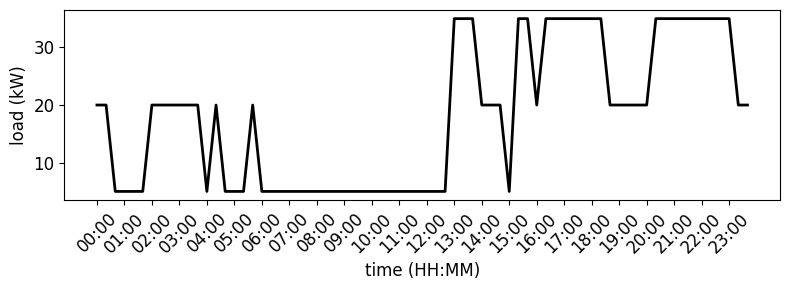

In [3]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'load_data_daily.pdf'
file_path = os.path.join(output_dir, file_name)
times = pd.date_range(start=f"{2020}-01-01 00:00", periods=24*3, freq='20min')
fig, ax = plt.subplots(1, 1, figsize=(8, 3), sharex=True)
ax.plot(times, w_test[24*3*365*2:24*3*(365*2+1)], label='load', color='black', linewidth=2)
ax.set_ylabel('load (kW)', fontsize=12)
ax.set_xlabel('time (HH:MM)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(False)
ax.set_xticks(pd.date_range(start=times.min(), end=times.max(), freq='60min'))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

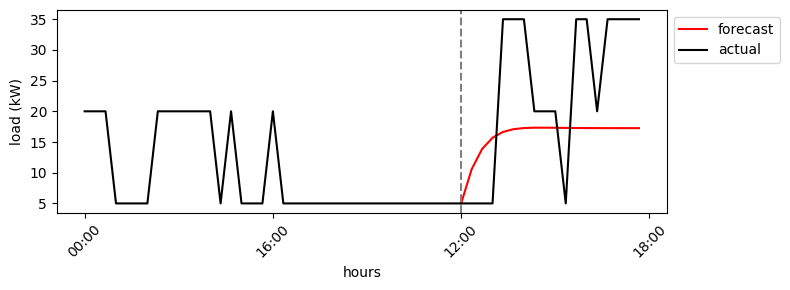

In [4]:
# 04-01-2018
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'load_forecasts_daily.pdf'
file_path = os.path.join(output_dir, file_name)

t1 = (24*3*365*2)+(H*4+8)-(15*3)
xindex_first_half = range(2*H)
xindex_second_half = range(2*H,3*H)
estimate1 = np.hstack([f_test[t1-2*H],f_test[t1-H],hat_f_test[t1]])
actual1 = np.hstack([f_test[t1-2*H],f_test[t1-H],f_test[t1]])

fig, ax = plt.subplots(1, 1, figsize=(8, 3)) 
ax.plot(xindex_second_half, estimate1[2*H:], color = 'red', label = 'forecast')
ax.plot(actual1, color = 'black', label = 'actual')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('load (kW)')
ax.grid(False)
ax.axvline(2*H, color='gray', linestyle='--')
ax.set_xticks([0,H,2*H,3*H])
ax.set_xticklabels(['00:00','16:00', '12:00', '18:00'], rotation = 45, ha = 'center')
ax.set_xlabel('hours')
plt.tight_layout()
#fig.savefig(file_path, bbox_inches='tight')
plt.show()

In [5]:
# Loop over gammas
list_battery_variables = []
list_cell_variables = []
list_rms_difference_raw = []
list_rms_difference_smoothed = []
list_battery_lifetime = []
cons_frac = 0.5
cons_mu = 0.5
cons_gammas = [0.0, 10000000.0, 21500000.0, 21550000.0, 21555000.0, 21560000.0, 21570000.0]
for cons_gamma in cons_gammas:
    battery_variables, cell_variables, rms_difference_raw, rms_difference_smoothed, battery_lifetime = smoothing_experiment(hat_f_test, cell_constants, cons_frac, cons_mu, cons_gamma)
    print(f'gamma = {cons_gamma:.3f} -> battery lifetime = {battery_lifetime:.3f}, smoothing = {1-(rms_difference_smoothed/rms_difference_raw):.3f}')
    list_battery_variables.append(battery_variables)
    list_cell_variables.append(cell_variables)
    list_rms_difference_raw.append(rms_difference_raw)
    list_rms_difference_smoothed.append(rms_difference_smoothed)
    list_battery_lifetime.append(battery_lifetime)

gamma = 0.000 -> battery lifetime = 11.113, smoothing = 0.957
gamma = 10000000.000 -> battery lifetime = 12.872, smoothing = 0.853
gamma = 21500000.000 -> battery lifetime = 14.952, smoothing = 0.732
gamma = 21550000.000 -> battery lifetime = 16.237, smoothing = 0.618
gamma = 21555000.000 -> battery lifetime = 17.257, smoothing = 0.557
gamma = 21560000.000 -> battery lifetime = 19.042, smoothing = 0.480
gamma = 21570000.000 -> battery lifetime = 21.766, smoothing = 0.398


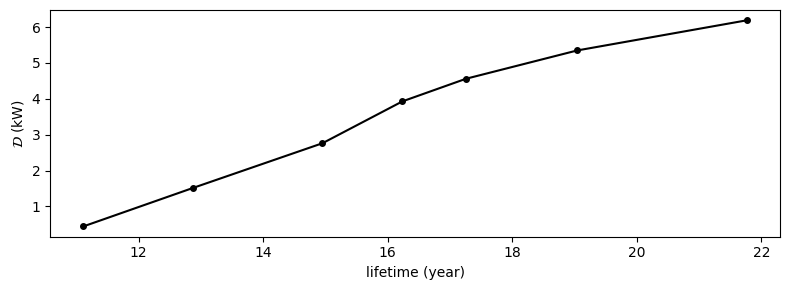

In [7]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'smoothing_tradeoff_curve.pdf'
file_path = os.path.join(output_dir, file_name)
lifetimes = np.array(list_battery_lifetime)
rmsds = np.array(list_rms_difference_smoothed)
fig, axes = plt.subplots(1, 1, figsize=(8, 3))
axes.plot(lifetimes, rmsds, color = 'black', linestyle = 'solid', marker = 'o', markersize = 4)
axes.set_xlabel('lifetime (year)')
axes.set_ylabel(r'$\mathcal{D}$ (kW)')
axes.grid(False)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches = 'tight')
plt.show()

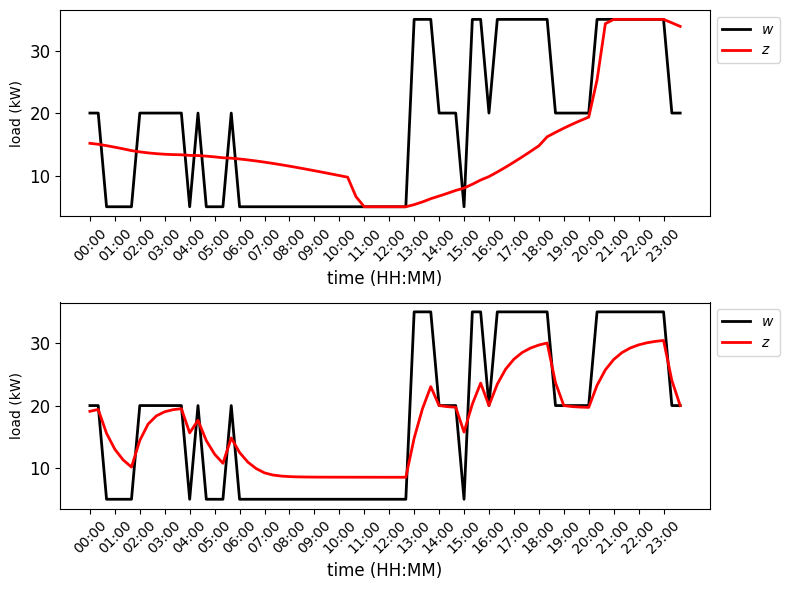

In [8]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'daily_profile_smoothing_perfect.pdf'
file_path = os.path.join(output_dir, file_name)
colors = [coolwarm(k) for k in np.linspace(0, 1, 5)]

w_greedy = list_battery_variables[0]['w']
z_greedy = list_battery_variables[0]['z']
b_greedy = list_cell_variables[0]['tilde_b']*cell_constants['tilde_V']*cell_constants['N']


w = list_battery_variables[2]['w']
z = list_battery_variables[2]['z']
b = list_cell_variables[2]['tilde_b']*cell_constants['tilde_V']*cell_constants['N']


times_subset_jan = pd.date_range(start=f'{2020}-01-01 00:00', end=f'{2020}-01-01 23:40', freq='20min')
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
axes[0].plot(times_subset_jan, w_greedy[24*3*365*2:24*3*(365*2+1)], label=r'$w$', color="black", linewidth=2)
axes[0].plot(times_subset_jan, z_greedy[24*3*365*2:24*3*(365*2+1)], label=r'$z$', color="red", linewidth=2)
axes[0].set_ylabel('load (kW)', color="black", fontsize=10)
axes[0].set_xlabel('time (HH:MM)', fontsize=12)
axes[0].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
axes[0].grid(False)
axes[0].legend(loc = 'upper left', bbox_to_anchor=(1, 1))
axes[0].set_xticks(pd.date_range(start=f'{2020}-01-01 00:00', end=f'{2020}-01-01 23:40', freq='60min'))
axes[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(times_subset_jan, w[24*3*365*2:24*3*(365*2+1)], label=r'$w$', color="black", linewidth=2)
axes[1].plot(times_subset_jan, z[24*3*365*2:24*3*(365*2+1)], label=r'$z$', color="red", linewidth=2)
axes[1].set_ylabel('load (kW)', color="black", fontsize=10)
axes[1].set_xlabel('time (HH:MM)', fontsize=12)
axes[1].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
axes[1].grid(False)
axes[1].legend(loc = 'upper left', bbox_to_anchor=(1, 1))
axes[1].set_xticks(pd.date_range(start=f"{2020}-01-01 00:00", end=f"{2020}-01-01 23:40", freq='60min'))
axes[1].xaxis.set_major_formatter(DateFormatter('%H:%M'))
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()